## Physical Activity Regression Analysis (A Data-Centric Approach)

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Import file

In [2]:
df_raw = pd.read_csv('nutrition_data.csv')

### Initial Exploratory Data Analysis

In [3]:
# https://stackoverflow.com/questions/38462920/pandas-keyerror-value-not-in-index
# https://www.geeksforgeeks.org/remove-spaces-from-column-names-in-pandas/

df_raw.columns = df_raw.columns.str.replace(' ', '')

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53392 entries, 0 to 53391
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   53392 non-null  int64  
 1   YearEnd                     53392 non-null  int64  
 2   LocationAbbr                53392 non-null  object 
 3   LocationDesc                53392 non-null  object 
 4   Datasource                  53392 non-null  object 
 5   Class                       53392 non-null  object 
 6   Topic                       53392 non-null  object 
 7   Question                    53392 non-null  object 
 8   Data_Value_Unit             0 non-null      float64
 9   Data_Value_Type             53392 non-null  object 
 10  Data_Value                  48346 non-null  float64
 11  Data_Value_Alt              48346 non-null  float64
 12  Data_Value_Footnote_Symbol  5046 non-null   object 
 13  Data_Value_Footnote         504

In [5]:
df_raw.describe()

YearStart       YearEnd  Data_Value_Unit    Data_Value  \
count  53392.000000  53392.000000              0.0  48346.000000   
mean    2013.281465   2013.281465              NaN     31.156681   
std        1.693300      1.693300              NaN     10.247033   
min     2011.000000   2011.000000              NaN      0.900000   
25%     2012.000000   2012.000000              NaN     24.100000   
50%     2013.000000   2013.000000              NaN     30.700000   
75%     2015.000000   2015.000000              NaN     37.000000   
max     2016.000000   2016.000000              NaN     77.600000   

       Data_Value_Alt  Low_Confidence_Limit  High_Confidence_Limit  \
count    48346.000000          48346.000000           48346.000000   
mean        31.156681             26.892227              35.989997   
std         10.247033             10.038584              11.205813   
min          0.900000              0.300000               3.000000   
25%         24.100000             20.000000              28.200000   
50%         30.700000             26.450000              35.600000   
75%         37.000000             32.900000              42.200000   
max         77.600000             69.500000              87.700000   

        Sample_Size    LocationID  
count   48346.00000  53392.000000  
mean     3889.19286     30.282215  
std     19829.42129     16.821318  
min        50.00000      1.000000  
25%       566.00000     17.000000  
50%      1209.00000     30.000000  
75%      2519.00000     44.000000  
max    476876.00000     78.000000

In [6]:
df_raw.head(3)

YearStart  YearEnd LocationAbbr LocationDesc  \
0       2011     2011           AL      Alabama   
1       2011     2011           AL      Alabama   
2       2011     2011           AL      Alabama   

                                   Datasource                    Class  \
0  Behavioral Risk Factor Surveillance System  Obesity / Weight Status   
1  Behavioral Risk Factor Surveillance System  Obesity / Weight Status   
2  Behavioral Risk Factor Surveillance System  Obesity / Weight Status   

                     Topic                                           Question  \
0  Obesity / Weight Status  Percent of adults aged 18 years and older who ...   
1  Obesity / Weight Status  Percent of adults aged 18 years and older who ...   
2  Obesity / Weight Status  Percent of adults aged 18 years and older who ...   

   Data_Value_Unit Data_Value_Type  ...  \
0              NaN           Value  ...   
1              NaN           Value  ...   
2              NaN           Value  ...   

                               GeoLocation  ClassID TopicID QuestionID  \
0  (32.84057112200048, -86.63186076199969)      OWS    OWS1       Q036   
1  (32.84057112200048, -86.63186076199969)      OWS    OWS1       Q036   
2  (32.84057112200048, -86.63186076199969)      OWS    OWS1       Q036   

   DataValueTypeID  LocationID  StratificationCategory1 Stratification1  \
0            VALUE           1                    Total           Total   
1            VALUE           1                   Gender            Male   
2            VALUE           1                   Gender          Female   

  StratificationCategoryId1 StratificationID1  
0                       OVR           OVERALL  
1                       GEN              MALE  
2                       GEN            FEMALE  

[3 rows x 33 columns]

#### Data Cleaning
- Remove columns for the following reasons:
    1. Duplicated column(s) either in values or in representation (e.g., Location equivalent to Location in Abbreviation) 
    2. A column of Nan's
    3. A column of the same value
    4. A column that's a composite values of multiple columns
    5. A non-important column with missing values

In [7]:
def initial_cleaning(df):
  
  df = df.drop(['YearEnd', 'Datasource', 'LocationAbbr','Data_Value_Unit', 'Topic','Data_Value_Type','Data_Value_Alt','Data_Value_Footnote','Data_Value_Footnote_Symbol','Total','DataValueTypeID','TopicID','GeoLocation','StratificationCategory1','Stratification1','StratificationCategoryId1','StratificationID1', 'LocationID'], axis=1)
  
  return df

In [8]:
df_cleaned = initial_cleaning(df_raw)

In [9]:
df_cleaned.head(3)

YearStart LocationDesc                    Class  \
0       2011      Alabama  Obesity / Weight Status   
1       2011      Alabama  Obesity / Weight Status   
2       2011      Alabama  Obesity / Weight Status   

                                            Question  Data_Value  \
0  Percent of adults aged 18 years and older who ...        32.0   
1  Percent of adults aged 18 years and older who ...        32.3   
2  Percent of adults aged 18 years and older who ...        31.8   

   Low_Confidence_Limit  High_Confidence_Limit  Sample_Size Age(years)  \
0                  30.5                   33.5       7304.0        NaN   
1                  29.9                   34.7       2581.0        NaN   
2                  30.0                   33.6       4723.0        NaN   

  Education  Gender Income Race/Ethnicity ClassID QuestionID  
0       NaN     NaN    NaN            NaN     OWS       Q036  
1       NaN    Male    NaN            NaN     OWS       Q036  
2       NaN  Female    NaN            NaN     OWS       Q036

#### Data Filtering the rows that answer the following question:
- Percent of adults who engage in muscle-strengthening activities on 2 or more days a week

In [10]:
activities = df_cleaned[(df_cleaned['QuestionID'] == 'Q046') & (df_cleaned['Age(years)'].notnull() )]

In [11]:
activities.head(3)

YearStart LocationDesc              Class  \
125       2011      Alabama  Physical Activity   
206       2011      Alabama  Physical Activity   
208       2011      Alabama  Physical Activity   

                                              Question  Data_Value  \
125  Percent of adults who engage in muscle-strengt...        16.8   
206  Percent of adults who engage in muscle-strengt...        41.6   
208  Percent of adults who engage in muscle-strengt...        28.3   

     Low_Confidence_Limit  High_Confidence_Limit  Sample_Size Age(years)  \
125                  14.5                   19.3       1721.0    55 - 64   
206                  35.6                   47.9        365.0    18 - 24   
208                  24.7                   32.1        882.0    35 - 44   

    Education Gender Income Race/Ethnicity ClassID QuestionID  
125       NaN    NaN    NaN            NaN      PA       Q046  
206       NaN    NaN    NaN            NaN      PA       Q046  
208       NaN    NaN    NaN            NaN      PA       Q046

In [12]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 125 to 45719
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   YearStart              948 non-null    int64  
 1   LocationDesc           948 non-null    object 
 2   Class                  948 non-null    object 
 3   Question               948 non-null    object 
 4   Data_Value             948 non-null    float64
 5   Low_Confidence_Limit   948 non-null    float64
 6   High_Confidence_Limit  948 non-null    float64
 7   Sample_Size            948 non-null    float64
 8   Age(years)             948 non-null    object 
 9   Education              0 non-null      object 
 10  Gender                 0 non-null      object 
 11  Income                 0 non-null      object 
 12  Race/Ethnicity         0 non-null      object 
 13  ClassID                948 non-null    object 
 14  QuestionID             948 non-null    object 
dtypes:

#### Additional Data Cleaning
- Remove columns for the following reasons:
    1. Duplicated column(s) either in values or in representation (e.g., Location equivalent to Location in Abbreviation)
    2. Column(s) of Nan's
    3. Column(s) of the same value

In [13]:
data = activities.drop(['Education', 'Gender', 'Income', 'Race/Ethnicity', 'ClassID', 'Class', 'Question', 'QuestionID'], axis = 1)

In [14]:
data.describe()

YearStart  Data_Value  Low_Confidence_Limit  High_Confidence_Limit  \
count   948.000000  948.000000            948.000000             948.000000   
mean   2013.025316   30.197152             26.509177              34.131962   
std       1.638822    8.936158              7.737033              10.270042   
min    2011.000000    3.300000              2.500000               4.400000   
25%    2011.000000   24.000000             21.300000              26.700000   
50%    2013.000000   28.700000             25.300000              32.150000   
75%    2015.000000   35.300000             31.000000              39.925000   
max    2015.000000   57.200000             49.800000              65.900000   

         Sample_Size  
count     948.000000  
mean     2758.830169  
std     11273.299744  
min        78.000000  
25%       598.000000  
50%      1116.500000  
75%      1917.750000  
max    148242.000000

### Exploratory Data Analysis on a Clean Dataset

#### Distribution of response variable (Data_Value) is roughly normal

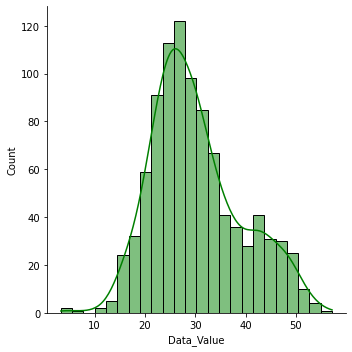

In [15]:
sns.displot(data['Data_Value'], color = 'green', kde = True);

#### Distribution of numerical explanatory variables
- Explanatory variables Low_Confidence_Limit & High_Confidence_Limit share a similar distribution with the response variable

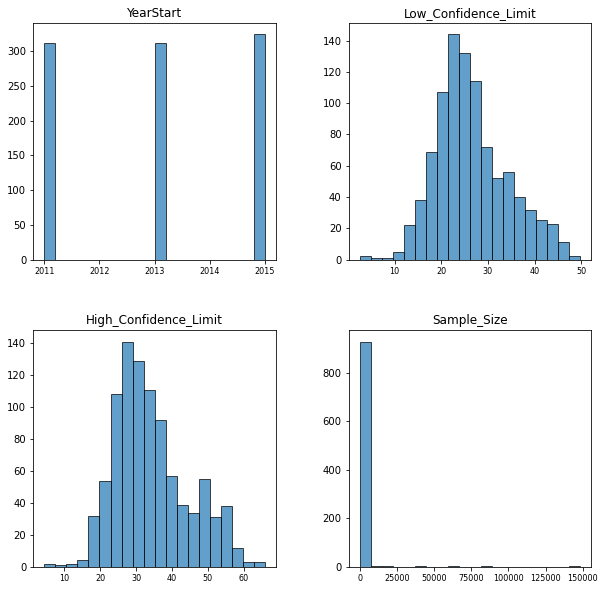

In [16]:
data.loc[:, data.columns != 'Data_Value'].hist(figsize = (10, 10), bins = 20, xlabelsize = 8, alpha = 0.7, grid = False, edgecolor = 'black');

#### Pair plots of numerical explanatory variables
- Pair plots show how the samples are spread with respect to two attributes ONLY.
- The samples are spread on a linear pattern for Low_Confidence_Limit vs High_Confidence_Limit.
    - It means the two attributes are linearly related in this dataset.
- The relationships of Sample_Size vs Low_Confidence_Limit & Sample_Size vs High_Confidence_Limit are not clear.

/tmp/ipykernel_619/1589214711.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)


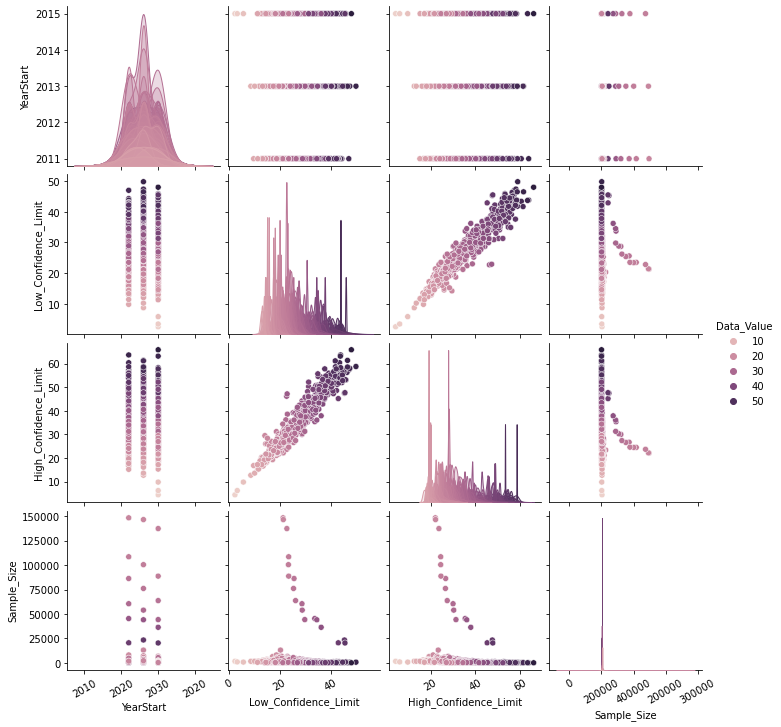

In [17]:
# https://www.delftstack.com/howto/seaborn/rotate-tick-labels-seaborn/
# https://python.tutorialink.com/how-to-rotate-labels-in-a-seaborn-pairgrid/
# https://stackoverflow.com/questions/60843085/how-to-rotate-labels-in-a-seaborn-pairgrid

pp1 = sns.pairplot(data, hue = 'Data_Value');

for ax in pp1.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)

#### Pair plots of explanatory variables vs. response variable
- Linear relationships:
    - Low_Confidence_Limit vs Data_Value 
    - High_Confidence_Limit vs Data_Value
    - Age(years) vs Data_Value

In [18]:
# set categorical order
# https://www.py4u.net/discuss/215386

data['Age(years)'] = pd.Categorical(data['Age(years)'], 
                                    categories = ['18 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65 or older'], 
                                    ordered = True)

/tmp/ipykernel_619/4202233822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)


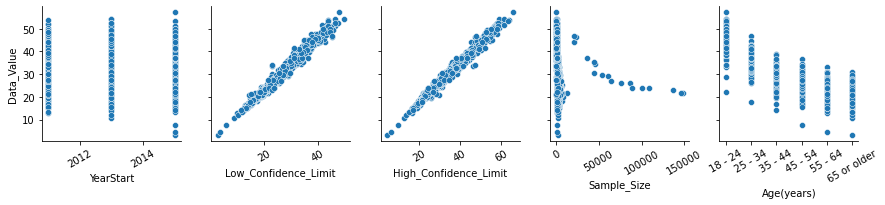

In [19]:
# https://stackoverflow.com/questions/31966494/compare-1-independent-vs-many-dependent-variables-using-seaborn-pairplot-in-an-h

pp2 = sns.pairplot(data.loc[:, data.columns != 'LocationDesc'], 
                   x_vars = ['YearStart', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Sample_Size', 'Age(years)'], 
                   y_vars = ['Data_Value']);

for ax in pp2.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)

#### Numerical Feature-to-Feature Relationships
- Correlation measures the strength and direction of a linear relationship between two variables.
    - Values always range between -1 (strong negative relationship) and +1 (strong positive relationship).
    - The closer it is to 0, the weaker the relation.
    - No inference can be made about nonlinearities (they might exist even if correlation is very low).
- There is a strong positive linear relationship between Low_Confidence_Limit and High_Confidence_Limit.

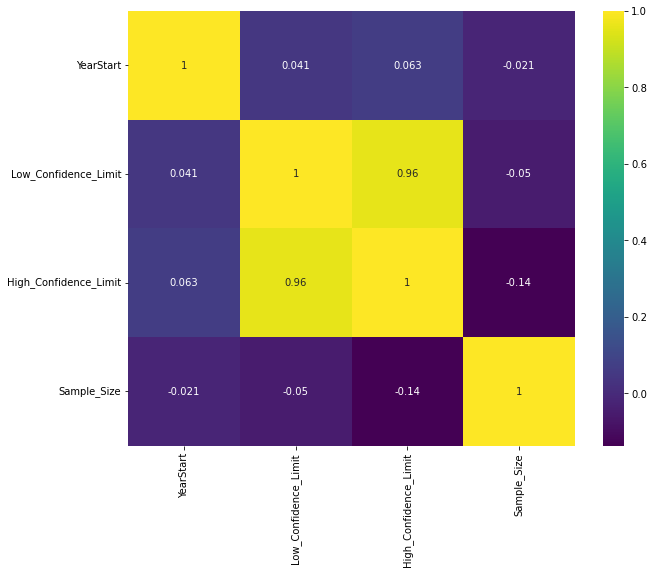

In [20]:
corr_features = data.loc[:, data.columns != 'Data_Value'].corr()

plt.figure(figsize = (10,8)) 
sns.heatmap(corr_features, 
            xticklabels = corr_features.columns.values, 
            yticklabels = corr_features.columns.values, 
            cmap='viridis', annot = True)
plt.show()

#### Correlation between numerical features and response variable
- There is a strong positive linear relationship between Low_Confidence_Limit vs Data_Value and High_Confidence_Limit vs Data_Value.

In [21]:
# https://datascience.stackexchange.com/questions/19293/how-pairplot-is-constructed-based-on-what-rule-why-people-use-it
# https://stackoverflow.com/questions/52497451/compute-correlation-between-features-and-target-variable

corr_response = data.loc[:, data.columns != 'Data_Value'].corrwith(data['Data_Value'])
corr_response

YearStart                0.052844
Low_Confidence_Limit     0.988211
High_Confidence_Limit    0.991426
Sample_Size             -0.098568
dtype: float64

### Build Regression Models

#### One-Hot Encoding of Categorical Features (Location & Age)

In [22]:
# https://stackoverflow.com/questions/48758744/creating-dummy-variables-for-multiple-cateogorical-variables-in-python
# https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40

dataset = pd.get_dummies(data, columns = ['LocationDesc','Age(years)'], drop_first = False, prefix = ['Location', 'Age'])

In [23]:
dataset.head(3)

YearStart  Data_Value  Low_Confidence_Limit  High_Confidence_Limit  \
125       2011        16.8                  14.5                   19.3   
206       2011        41.6                  35.6                   47.9   
208       2011        28.3                  24.7                   32.1   

     Sample_Size  Location_Alabama  Location_Alaska  Location_Arizona  \
125       1721.0                 1                0                 0   
206        365.0                 1                0                 0   
208        882.0                 1                0                 0   

     Location_Arkansas  Location_California  ...  Location_Washington  \
125                  0                    0  ...                    0   
206                  0                    0  ...                    0   
208                  0                    0  ...                    0   

     Location_West Virginia  Location_Wisconsin  Location_Wyoming  \
125                       0                   0                 0   
206                       0                   0                 0   
208                       0                   0                 0   

     Age_18 - 24  Age_25 - 34  Age_35 - 44  Age_45 - 54  Age_55 - 64  \
125            0            0            0            0            1   
206            1            0            0            0            0   
208            0            0            1            0            0   

     Age_65 or older  
125                0  
206                0  
208                0  

[3 rows x 65 columns]

#### Construct 2 datasets for the remaining proof-of-concept:
- a full dataset 
- a dataset of the original experiment

In [24]:
# https://stackoverflow.com/questions/53052914/selecting-non-adjacent-columns-by-column-number-pandas
x_fullset = dataset.iloc[:, np.r_[0, 2:65]]

In [25]:
# https://stackoverflow.com/questions/29763620/how-to-select-all-columns-except-one-column-in-pandas
# x_fullset.loc[:, ~x_fullset.columns.isin(['Low_Confidence_Limit', 'High_Confidence_Limit', 'Sample_Size'])]
x_subset = dataset.iloc[:, np.r_[0, 5:65]]

In [26]:
y_target = dataset.iloc[:,1]

#### Split the datasets into training and testing

In [27]:
# Split the data into training/testing sets and split the targets into training/testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(x_fullset, y_target, test_size = 0.2, random_state = 0)

In [28]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(x_subset, y_target, test_size = 0.2, random_state = 0)

#### Create and train the following regression models: OLS, Lasso, Ridge, ElasticNet

- OLS full dataset

In [29]:
# Create OLS object of the full dataset
# Train the model using the training portion of the subset dataset

regress_model_full = LinearRegression()
regress_model_full.fit(X_train_full, y_train_full)

LinearRegression()

- OLS subset

In [30]:
# Create a OLS object of the subset dataset
# Train the model using the training portion of the subset dataset

regress_model_sub = LinearRegression()
regress_model_sub.fit(X_train_sub, y_train_sub)

LinearRegression()

- Lasso subset

In [31]:
# Create a lasso object and fit it with the training portion of the subset dataset
# https://machinelearningmastery.com/lasso-regression-with-python/

lasso_model_sub = Lasso(alpha = 0.01)
lasso_model_sub.fit(X_train_sub, y_train_sub)

Lasso(alpha=0.01)

- Ridge subset

In [32]:
# Create a ridge object and fit it with the training portion of the subset dataset

ridge_model_sub = Ridge(alpha = 0.01)
ridge_model_sub.fit(X_train_sub, y_train_sub)

Ridge(alpha=0.01)

- ElasticNet subset

In [33]:
# Create an elasticNet object and fit it with the training portion of the subset dataset

ElasticNet_model_sub = ElasticNet(alpha = 0.005)
ElasticNet_model_sub.fit(X_train_sub, y_train_sub)

ElasticNet(alpha=0.005)

### 10-Fold Cross-Validation

In [34]:
# https://stackoverflow.com/questions/24132237/scikit-learn-cross-validation-scoring-for-regression
# https://scikit-learn.org/stable/modules/cross_validation.html
# https://stackoverflow.com/questions/51477339/box-plots-in-python-using-seaborn-creating-duplicates-for-bigrams-and-trigrams
# https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

def CVresults(models_names, models, X_mdl, y_mdl, CV):
    i = 0
    lst = []
    
    for model in models:
        scoring = cross_val_score(model, X_mdl[i], y_mdl[i], cv = CV, n_jobs = -1)
        lst.append(scoring.tolist())
        i = i + 1
    
    cv_result = pd.DataFrame.from_records(lst)
    cv_result = cv_result.T
    cv_result.columns = models_names
    boxplots = cv_result.boxplot()
    boxplots
    
    return

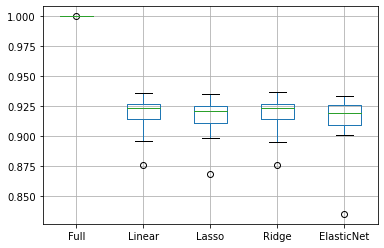

In [35]:
models_names = ['Full','Linear','Lasso', 'Ridge','ElasticNet']
models = [regress_model_full, regress_model_sub, lasso_model_sub, ridge_model_sub, ElasticNet_model_sub]
X_mdl = [X_train_full, X_train_sub, X_train_sub, X_train_sub, X_train_sub]
y_mdl = [y_train_full, y_train_sub, y_train_sub, y_train_sub, y_train_sub]
CV = 10
CVresults(models_names, models, X_mdl, y_mdl, CV)

### Predictions using regression models

In [36]:
y_pred_full = regress_model_full.predict(X_test_full)
y_pred_sub = regress_model_sub.predict(X_test_sub)
y_pred_sub_lasso = lasso_model_sub.predict(X_test_sub)
y_pred_sub_ridge = ridge_model_sub.predict(X_test_sub)
y_pred_sub_ElasticNet = ElasticNet_model_sub.predict(X_test_sub)

In [37]:
prediction_table = pd.DataFrame({'Actual': y_test_full, 'Predicted_Full_Set': y_pred_full, 'Predicted_Subset': y_pred_sub, 'Predicted_Subset_Lasso': y_pred_sub_lasso, 'Predicted_Subset_Ridge': y_pred_sub_ridge, 'Predicted_Subset_ElasticNet': y_pred_sub_ElasticNet})
prediction_table.head(6)

Actual  Predicted_Full_Set  Predicted_Subset  Predicted_Subset_Lasso  \
44040    18.9           18.901202         21.658203               22.247439   
32020    28.7           28.738445         25.695312               25.242119   
14079    29.3           29.306547         28.195312               27.596306   
18775    35.3           35.305336         35.714844               35.903728   
27925    46.7           46.765767         43.414062               44.010236   
39832    26.3           26.336413         26.533203               26.064505   

       Predicted_Subset_Ridge  Predicted_Subset_ElasticNet  
44040               21.664760                    21.977569  
32020               25.700506                    25.400813  
14079               28.191737                    27.830570  
18775               35.720209                    35.449188  
27925               43.405783                    43.458236  
39832               26.523601                    26.064921

#### Model Comparisons - Prediction Visualization

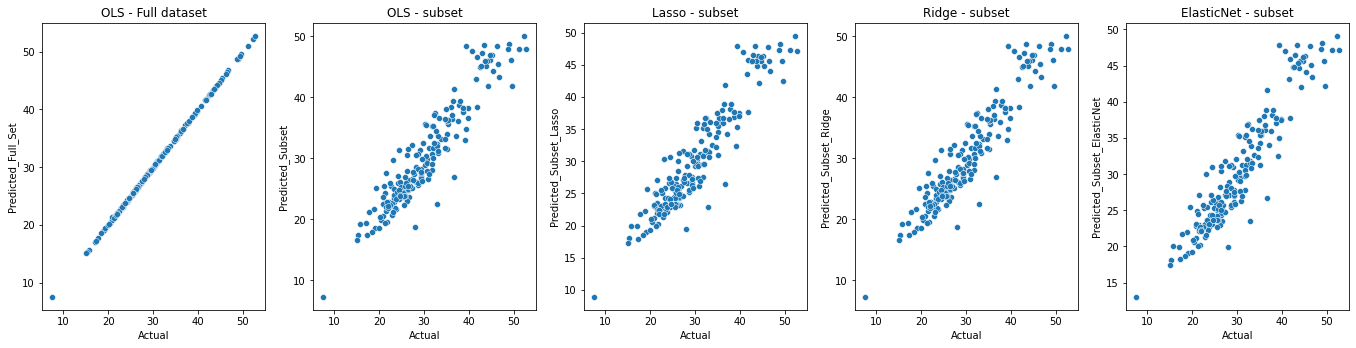

In [38]:
# https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side
# https://seaborn.pydata.org/generated/seaborn.scatterplot.html
# https://www.journaldev.com/39381/seaborn-scatter-plot
# https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib

dims = (19, 5)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = dims)

ax1.title.set_text('OLS - Full dataset')
ax2.title.set_text('OLS - subset')
ax3.title.set_text('Lasso - subset')
ax4.title.set_text('Ridge - subset')
ax5.title.set_text('ElasticNet - subset')

sns.scatterplot(x = prediction_table['Actual'], y = prediction_table['Predicted_Full_Set'], alpha = 1, ax = ax1)
sns.scatterplot(x = prediction_table['Actual'], y = prediction_table['Predicted_Subset'], alpha = 1, ax = ax2)
sns.scatterplot(x = prediction_table['Actual'], y = prediction_table['Predicted_Subset_Lasso'], alpha = 1, ax = ax3)
sns.scatterplot(x = prediction_table['Actual'], y = prediction_table['Predicted_Subset_Ridge'], alpha = 1, ax = ax4)
sns.scatterplot(x = prediction_table['Actual'], y = prediction_table['Predicted_Subset_ElasticNet'], alpha = 1, ax = ax5)

sns.set(style = 'ticks')
plt.tight_layout()
plt.show()

#### Model Comparisons - Error Summary

In [39]:
# initialize a list https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

errors = {'Errors':['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Coefficient of determination (R-squared): %.2f'], 
          'Full Set':[mean_absolute_error(y_test_full, y_pred_full), mean_squared_error(y_test_full, y_pred_full), np.sqrt(mean_squared_error(y_test_full, y_pred_full)), r2_score(y_test_full, y_pred_full)], 
          'Subset':[mean_absolute_error(y_test_sub, y_pred_sub), mean_squared_error(y_test_sub, y_pred_sub), np.sqrt(mean_squared_error(y_test_sub, y_pred_sub)), r2_score(y_test_sub, y_pred_sub)],
          'Lasso Subset':[mean_absolute_error(y_test_sub, y_pred_sub_lasso), mean_squared_error(y_test_sub, y_pred_sub_lasso), np.sqrt(mean_squared_error(y_test_sub, y_pred_sub_lasso)), r2_score(y_test_sub, y_pred_sub_lasso)],
          'Ridge Subset':[mean_absolute_error(y_test_sub, y_pred_sub_ridge), mean_squared_error(y_test_sub, y_pred_sub_ridge), np.sqrt(mean_squared_error(y_test_sub, y_pred_sub_ridge)), r2_score(y_test_sub, y_pred_sub_ridge)],
          'ElasticNet Subset':[mean_absolute_error(y_test_sub, y_pred_sub_ElasticNet), mean_squared_error(y_test_sub, y_pred_sub_ElasticNet), np.sqrt(mean_squared_error(y_test_sub, y_pred_sub_ElasticNet)), r2_score(y_test_sub, y_pred_sub_ElasticNet)]}
error_summary = pd.DataFrame(errors)
error_summary

Errors  Full Set    Subset  \
0                             Mean Absolute Error  0.041337  2.137835   
1                              Mean Squared Error  0.004119  8.357403   
2                         Root Mean Squared Error  0.064183  2.890917   
3  Coefficient of determination (R-squared): %.2f  0.999941  0.879412   

   Lasso Subset  Ridge Subset  ElasticNet Subset  
0      2.183392      2.137227           2.133528  
1      8.358361      8.356636           8.107010  
2      2.891083      2.890785           2.847281  
3      0.879398      0.879423           0.883024

### Conclusion
- The concept of data-centric approach in linear regression is tested.
- The notion of "Garbage-in, Garbage-out" holds.
    - The quality of the data defines the quality of the model. 